---
title: Finding the highest rated Christmas movies in MovieLens 10M  
date: 2015-12-23  
comments: false  
tags: Python, SQL, web scraping, pandas, matplotlib
keywords: python, programming, pandas, matplotlib, web scraping, movielens, christmas, sql  

---

It has been another scorching Christmas season in Melbourne, so I have been hiding in the aircon catching up on my holiday movies for the last week. I also (serendipitously) recently discovered the wonderful [MovieLens](http://grouplens.org/datasets/movielens/) datasets and have been messing around with some analyses using them, so I got curious about whether my favourite Christmas movies are in these datasets and what the raters actually think about them. I mean, I know in my heart that 'Die Hard' and 'Love Actually' are modern Christmas classics, but would the data agree with me?

To answer my questions, I used the [MovieLens 10M](http://grouplens.org/datasets/movielens/10m/), which has ratings up to 2009, and a list of the [top 50 Christmas movies](http://www.timeout.com/london/film/the-50-best-christmas-movies) from Time Out London.

<img src="/figure/die_hard_christmas.jpeg" title="Die Hard Christmas" alt="Die Hard is totally a Christmas movie, dammit." style="display: block; margin: auto;" />

## Setting up the virtualenv

To set up the environment for this analysis, I created a new virtualenv (see [this blog post]({filename}2015-11-18-reddit-api-part-1.md) on how to do this) and installed the following packages:

In [3]:
!pip install lxml
!pip install cssselect
!pip install requests
!pip install mysql-connector-python
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install jupyter

I then opened a new Jupyter notebook to run the rest of the analyses, but you can of course use your favourite Python IDE instead.

## Getting the list of Christmas movies

In order to get the list of Christmas movies, I created a short web scaping script that pulled the titles from the Time Out London list, cleaned them, and exported them to a text file. I will describe how I did this in detail in a later blog post, but for the keen I have put the code in [this gist](https://gist.github.com/t-redactyl/13cfc08629186e11fb12).

## Creating a database with the movies and ratings

MovieLens 10M is, as you can see from the name, a large dataset. It has around 10 million ratings of 10,681 movies by 71,567 users. Due to its size, I decided to speed my data processing up by importing the data into a MySQL database. MovieLens 10M has three available tables. **ratings.dat** contains the ratings of each movie, as well as a user ID, movie ID and the date and time of the rating (in Unix time). Ratings range from 1-5. **tag.dat** has the same structure as ratings.dat, but instead of the rating is a user-generated tag which describes the movie. Finally, **movies.dat** contains the same movie ID as in ratings.dat and tag.dat, the title of the movie, and the genres. Movies can have multiple genres.

Again, I will be doing a later blog post on setting up the SQL database and how to make it talk to pandas, but for now I have included the code in [this gist](https://gist.github.com/t-redactyl/6b519437844f297a4eca). At the end of these MySQL queries we have a database with 4 tables: the ratings (`ratingsdata`), the movies (`movies`), the list of Christmas movies (`christmas`) and the IDs of the Christmas movies (`christmasids`) that found a match in the `movies` table. Only 35 of the 50 movies were found in the MovieLens 10M dataset. Note I've also cleaned the movies data so that the genres column has been separated out into 18 new columns with a 0/1 value representing each genre. For example, if a movie was tagged as action and comedy, the `action` and `comedy` columns would be 1, while all of the other columns would be 0.

## What ratings are Christmas movies given?

The most obvious question to start with is what average rating each movie is given. To do this, I used the [MySQL Connector/Python package](https://dev.mysql.com/doc/connector-python/en/connector-python-introduction.html) to send the MySQL queries, and then stored the results in a `pandas` DataFrame. Let's send the first query. To do so, we first need to connect to our server and assign the connection to a cursor.

In [20]:
from pandas import Series, DataFrame
import pandas as pd
import mysql.connector

cnx = mysql.connector.connect(user='Jodie', password='j0d1e',
                              host='192.168.99.100',
                              database='MovieLens', 
                              port = 32769)
cursor = cnx.cursor()

In [22]:
query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid)
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df1 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'AverageRating'])
df1[:5]

,Title,AverageRating
0,"Christmas Story, A (1983)",4.1761
1,It's a Wonderful Life (1946),4.1568
2,Brazil (1985),4.1246
3,In Bruges (2008),4.1119
4,Kiss Kiss Bang Bang (2005),4.1001


In [17]:
#cnx.close()

Wonderful! We now have our 35 matched movies and their average rating in descending order. Let's take a look at the whole list using a barplot in `matplotlib`.

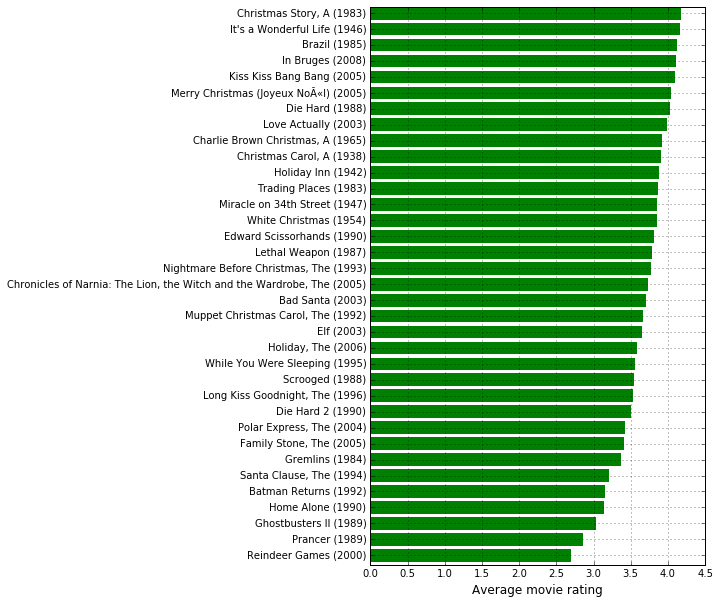

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(len(df1))

fig = plt.figure(figsize = (720/120, 1200/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df1['AverageRating'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df1['Title'])
plt.gca().invert_yaxis()
plt.xlabel('Average movie rating', fontsize = 12)
plt.grid(True)

We find that the top rating movies are 'A Christmas Story' and 'It's a Wonderful Life', while the worst rated movies are 'Prancer' and 'Reindeer Games'. My two favourites performed well, with 'Die Hard' getting a rating of 4.03 and 'Love Actually' a rating of 3.99 out of 5.

## Are Christmas movies rated differently in December compared to the rest of the year?

I then wondered whether the rating that MovieLens users gave to Christmas movies differed depending on whether they rated the movie in December compared to the rest of the year. On one hand, users may give movies higher scores around Christmas because they associate that movie with a feel-good holiday. On the other hand, they may give a movie a lower score because they are so sick of seeing it replayed on TV.

To do this, I ran two separate queries. One got the average score for a movie when the movie was rated between January to November, and the other the average score when it was rated in December.

In [25]:
# Average ratings for Christmas movies Jan-Nov

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND NOT MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
NotDec = DataFrame(cursor.fetchall(), 
                   columns = ['Title', 'AverageRating'])

In [26]:
# Average ratings for Christmas movies in December

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
Dec = DataFrame(cursor.fetchall(), 
                columns = ['Title', 'AverageRating'])

I then merged these two DataFrames, and created a new column taking the difference of the average rating in December from the average rating during the rest of the year. This means that positive scores mean the movie was rated better in December, while negative scores mean it was rated better during the rest of the year.

In [27]:
df2 = pd.merge(NotDec, Dec, left_on='Title', right_on='Title', how='outer')
df2['diff'] = df2['AverageRating_y'] - df2['AverageRating_x']

Finally, to present the graph in alphabetical order, I sorted the table by `Title` and reindexed the table.

In [28]:
df2 = df2.sort_values(by = 'Title')
df2.index = np.arange(0, len(df2), 1)

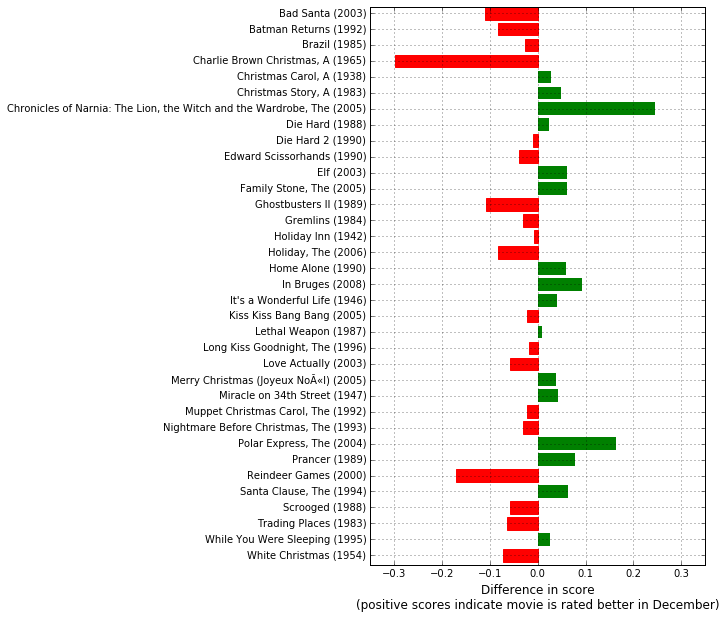

In [29]:
x = np.arange(len(df2))
idx = df2[df2['diff'] <= 0].index.tolist()

fig = plt.figure(figsize = (720/120, 1200/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df2['diff'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df2['Title'])
plt.gca().invert_yaxis()
for i in idx:
    barlist[i].set_color('r')
plt.xlabel('Difference in score\n(positive scores indicate movie is rated better in December)', fontsize = 12)
plt.xlim((-0.35, 0.35))
plt.grid(True)

Unsurprisingly, movies such as 'Elf', 'It's a Wonderful Life' and 'The Polar Express' are rated better in December than the rest of the year. 'The Lion, the Witch and the Wardrobe' also ranks better around Christmas than at any other time. However, one of the biggest surprises is how much worse 'A Charlie Brown Christmas' is rated at Christmas - everyone is sick of seeing it perhaps? Hilariously, 'Reindeer Games', which was already the worst rated film on the list, is rated almost 0.2 stars lower around Christmas.

## How have Christmas movies been rated over time?

Christmas movies may have also grown more or less popular since they were released. To have a look at the average rating of movies over time, we first run a MySQL query to get the average rating by movie and year:

In [31]:
query = ("""\
SELECT movies.title AS Title, 
    YEAR(FROM_UNIXTIME(ratingsdata.timestamp)) as Year,
	AVG(ratingsdata.rating) AS AverageRating
FROM movies
INNER JOIN ratingsdata
ON movies.itemid = ratingsdata.itemid
WHERE movies.itemid IN (
	SELECT christmasids.itemid
	FROM movies
	INNER JOIN christmasids
		ON movies.itemid = christmasids.itemid)
GROUP BY movies.title, Year;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df3 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'Year', 
                          'AverageRating'])

Some of the movies only have a couple years of data, as they were either recent releases or only recently introduced into the dataset. In order to get a good trend of data over time, I limited the data to those movies that have at least 5 years worth of data, and then took the difference of the first year from the last year, meaning that movies that have a positive difference have been rated better in more recent years.

In [32]:
g = df3.groupby('Title')
size = (g.size() >= 5)
df4 = df3[df3['Title'].isin(size[size].index)]
df4 = DataFrame(df4.groupby('Title').last()['AverageRating'] - 
                df4.groupby('Title').first()['AverageRating'])

I then created a `Title` column (rather than leaving it as the index) and made the index numeric to make the graphing easier (the code that changes the bar colours needs a numeric index).

In [33]:
df4['Title'] = df4.index
df4.index = np.arange(0, len(df4), 1)

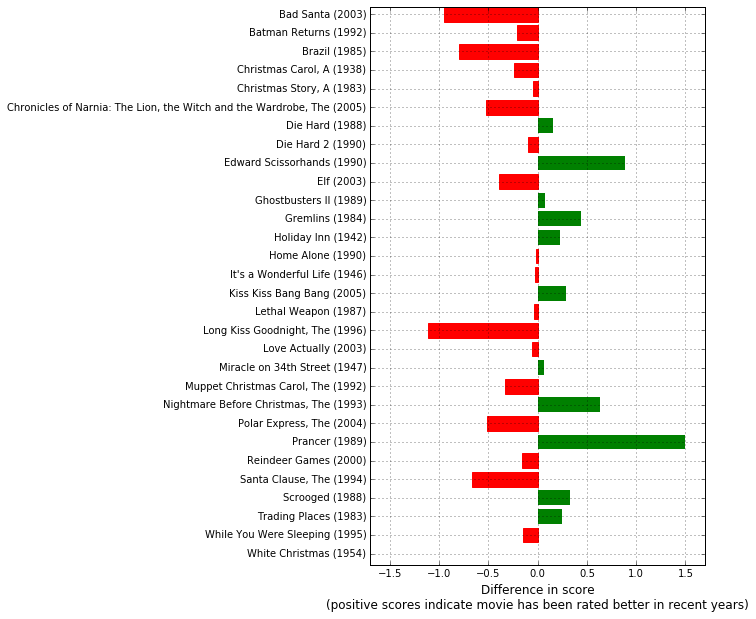

In [35]:
x = np.arange(len(df4))
idx = df4[df4['AverageRating'] <= 0].index.tolist()

fig = plt.figure(figsize = (720/120, 1200/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df4['AverageRating'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, df4['Title'])
plt.gca().invert_yaxis()
for i in idx:
    barlist[i].set_color('r')
plt.xlabel('Difference in score\n(positive scores indicate movie has been rated better in recent years)', fontsize = 12)
plt.xlim((-1.7, 1.7))
plt.grid(True)

Both of Tim Burton's Christmas movies have increased in popularity over time (probably as people realised these were two of his last good movies). Interestingly, a few of the movies that generally rate better in December have rated more poorly over time, with 'Elf' and 'Polar Express losing between around half a star over time. Again, 'It's a Wonderful Life', as well as my favourites 'Die Hard' and 'Love Actually' have remained pretty consistently highly rated over time. Finally poorly rated movies such as 'Reindeer Games' and 'Home Alone' have always been poorly rated. 

Below I will show a line plot of ratings from 2003-2009 of movies of each type. You can see 'Edward Scissorhand's ratings rise over the 6 years, while 'Elf's fall. Meanwhile, 'It's a Wonderful Life' hovers consistently around 4.2 and 'Home Alone' can't get above 3.4 (fully deserved, that movie is terrible). 

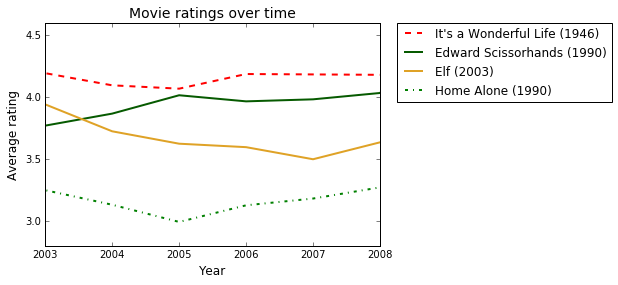

In [36]:
# Plot a movie rising in popularity, one that is always popular, one falling in popularity, and one always unpopular

fig = plt.figure(figsize = (720/120, 500/120), dpi = 120)                                                  
ax = fig.add_subplot(1,1,1)

# Add lines
plt.plot(df3['Year'].loc[df3['Title'] == df4['Title'][14]], 
         df3['AverageRating'].loc[df3['Title'] == df4['Title'][14]],
         color='#FF0000', linestyle='dashed', linewidth=2.0,
         label = df4['Title'][14])
plt.plot(df3['Year'].loc[df3['Title'] == df4['Title'][8]], 
         df3['AverageRating'].loc[df3['Title'] == df4['Title'][8]],
         color='#065A00', linewidth=2.0, 
         label = df4['Title'][8])
plt.plot(df3['Year'].loc[df3['Title'] == df4['Title'][9]], 
         df3['AverageRating'].loc[df3['Title'] == df4['Title'][9]], 
         color='#DFA226', linewidth=2.0,
         label = df4['Title'][9])
plt.plot(df3['Year'].loc[df3['Title'] == df4['Title'][13]], 
         df3['AverageRating'].loc[df3['Title'] == df4['Title'][13]], 
         color='green', linestyle='dashdot', linewidth=2.0, 
         label = df4['Title'][13])

# Add labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average rating', fontsize=12)
plt.title('Movie ratings over time', fontsize=14)

# Set x-axis
plt.xlim((2003, 2008))
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Create legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## What genres are Christmas movies?

I will end this post by looking at the most common genres of Christmas movies. We run a final MySQL query to extract the number of movies tagged with each genre. We can also now close our connection (using `cnx.close()`) as we are finished our queries.

In [37]:
query = ("""\
SELECT SUM(movies.action) AS Action, 
      SUM(movies.adventure) AS Adventure, 
      SUM(movies.animation) AS Animation,
      SUM(movies.childrens) AS Childrens, 
      SUM(movies.comedy) AS Comedy, 
      SUM(movies.crime) AS Crime,
      SUM(movies.documentary) AS Documentary, 
      SUM(movies.drama) AS Drama, 
      SUM(movies.fantasy) AS Fantasy,
      SUM(movies.noir) AS Noir, 
      SUM(movies.horror) AS Horror, 
      SUM(movies.musical) AS Musical,
      SUM(movies.mystery) AS Mystery, 
      SUM(movies.romance) AS Romance, 
      SUM(movies.scifi) AS SciFi,
      SUM(movies.thriller) AS Thriller, 
      SUM(movies.war) AS War, 
      SUM(movies.western) AS Western
FROM movies
WHERE movies.title IN (
   SELECT DISTINCT movies.title
   FROM movies
   LEFT JOIN ratingsdata
      ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid));
""")

cursor = cnx.cursor() 
cursor.execute(query)
df5 = DataFrame(cursor.fetchall(), 
               columns = ['Action', 'Adventure', 'Animation',
                          'Childrens', 'Comedy', 'Crime', 
                          'Documentary', 'Drama', 'Fantasy', 
                          'Noir', 'Horror', 'Musical', 'Mystery',
                          'Romance', 'SciFi', 'Thriller', 'War',
                          'Western'])
cnx.close()

Looking at the first 5 columns, you can see the data have been returned with a separate column per genre. This is not very helpful, so will require a little bit of wrangling to get it into a suitable form for graphing.

In [45]:
df5.ix[:,:5]

,Action,Adventure,Animation,Childrens,Comedy
0,9,3,3,9,22


In [46]:
df5 = df5.transpose()
df5.columns = ['Count']
df5 = df5.sort_values(by = 'Count', ascending = 0)

Now we have a transposed table which is sorted by the number of movies in each genre. Remember that movies can have more than one genre tag, so this table sums to more than 35. Here are the first 5 rows:

In [47]:
df5[:5]

,Count
Comedy,22
Drama,12
Fantasy,12
Romance,10
Action,9


Now we can plot the frequency of each genre using a barplot.

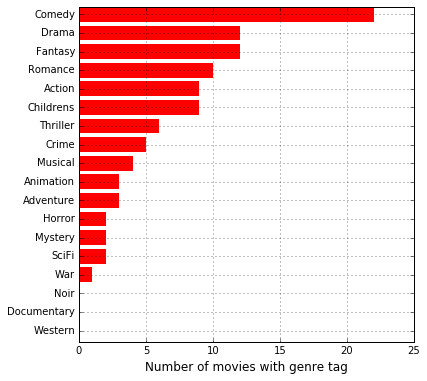

In [48]:
x = np.arange(len(df5))

fig = plt.figure(figsize = (720/120, 800/120), dpi = 120)
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, df5['Count'], color = "r",
                   edgecolor='none')
plt.yticks(x + 0.4, df5.index)
plt.gca().invert_yaxis()
plt.xlabel('Number of movies with genre tag', fontsize = 12)
plt.grid(True)

Unsurprisingly, comedy is by far and away the dominant genre, followed by drama, fantasy and romance. There are a surprisingly small number of musicals or animated movies, and a very high number of action movies, given the family-friendly nature of the holiday. There are also, oddly enough, two movies tagged as horror ('Gremlins' and 'Ghostbusters II') which seems a little incongruous for the Christmas season (though to be fair, they are both pretty ridiculous horror movies).